In [1]:
%pylab inline
from __future__ import print_function, division

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nibabel as nib
import numpy as np
import os
import stat
import os.path as osp
import matplotlib.pyplot as plt
import nipy
import json
import scipy.linalg as lin
import scipy.stats as sst
from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse

In [3]:
HOME = osp.expanduser('~')
atlas_rois = osp.join(HOME,'code', 'regions', 'regions','tmp')
DDIR = osp.join(HOME,'data','simpace','data','rename_files','sub01','sess01','preproc')
DSRA = osp.join(DDIR, 'smooth')

runs_pat = ['*sess01_run{:02d}-0*'.format(i) for i in [1,2,3,4]]

runs = [gb.glob(osp.join(DSRA, pat)) for pat in runs_pat]
for run in runs: run.sort()
print([len(run) for run in runs])
print('\n'.join(runs[0][:4]))

[196, 196, 196, 196]
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0005.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0006.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0007.nii
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/smooth/srasub01_sess01_run01-0008.nii


In [4]:
_img = nib.load(runs[0][10])
# print(_img.header)


## Step 0: compute fmri mask for this session

In [5]:
# import nilearn
import nilearn as nil
from nilearn import masking as msk
from nilearn.image.image import _compute_mean

mask = msk.compute_epi_mask(runs[0], opening=1, connected=True)
mean0, aff0 = _compute_mean(runs[0])
EXPECTEDSHAPE = (64,64,30,196)
assert mean0.shape == EXPECTEDSHAPE[:3]
# setup the directories

In [6]:
mask_sess = msk.compute_multi_epi_mask(runs, lower_cutoff=0.2, upper_cutoff=0.85,
                           connected=True, opening=2, threshold=0.5)


In [7]:
print(mean0.shape)
print(mask.shape)
print(mask.get_data().shape)
print(mask.get_data().dtype)

(64, 64, 30)
(64, 64, 30)
(64, 64, 30)
int8


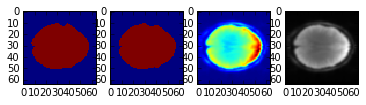

In [8]:
fig, ax = plt.subplots(1,4)
sli = 15
r = 142

ax[0].imshow(mask.get_data()[:,:,sli],interpolation='nearest')
ax[1].imshow(mask_sess.get_data()[:,:,sli],interpolation='nearest')
ax[2].imshow(mean0[:,:,sli],interpolation='nearest')
ax[3].imshow(nib.load(runs[0][r]).get_data()[:,:,sli],interpolation='nearest',cmap='gray')



## Step 2: extract roi signals

In [9]:
import importlib
import utils._utils as ucr
ucr = reload(ucr)
from nilearn._utils import concat_niimgs

In [10]:
run0_4d = concat_niimgs(runs[0], ensure_ndim=4)
print(run0_4d.get_data().dtype)
assert run0_4d.get_data().shape == EXPECTEDSHAPE
print(run0_4d.get_affine())
np.allclose(run0_4d.get_affine(), mask.get_affine())
print(run0_4d.shape)

print(run0_4d.get_data().mean())

float32
[[ -3.50000000e+00   3.49980461e-16  -1.31730564e-16   1.10184021e+02]
 [  3.50001478e-16   3.28892422e+00  -1.31677759e+00  -7.62047806e+01]
 [  0.00000000e+00   1.19707048e+00   3.61781669e+00  -6.83810883e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
(64, 64, 30, 196)
163.977


In [11]:
DROI = osp.join(DDIR, 'registered_files')
roi_prefix = 'rraal_*.nii'

#rois = gb.glob(osp.join(DROI, roi_prefix))

signals, issues, info = ucr.extract_signals(DROI, roi_prefix, run0_4d, 
                                                    mask=mask, minvox=1)

utils/_utils.py:261: RuntimeWarning: invalid value encountered in greater
  roi_mask = np.asarray(img.get_data().astype(float) > roi_threshold)


193


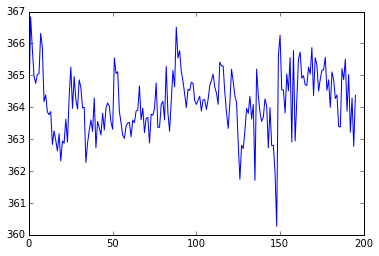

In [12]:
plt.plot(signals['rraal_Thalamus_R__________'])
print(info['rraal_Thalamus_L__________'])

In [13]:
sig_keys = set(signals.keys())
iss_keys = set(issues.keys())
assert not sig_keys.intersection(iss_keys)

In [14]:
signals['rraal_Amygdala_L__________'][:10]

array([ 353.25      ,  354.28570557,  352.82144165,  352.67855835,
        352.10714722,  352.10714722,  352.39285278,  351.96429443,
        350.64285278,  351.53570557], dtype=float32)

In [15]:
arr_sig, labs = ucr._dict_signals_to_arr(signals)

print(arr_sig.shape, len(labs))
assert (len(signals) == len(labs))

roi_label = 'rraal_Thalamus_R__________'
idx_roi = labs.index(roi_label)
print(info.values()[idx_roi])
assert np.allclose(signals[roi_label], arr_sig[:,idx_roi])

(196, 102) 102
47


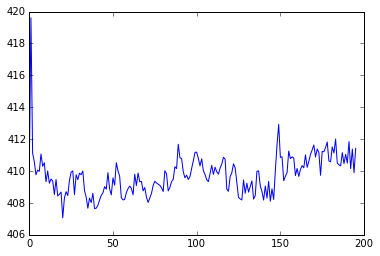

In [16]:
labs.index('rraal_Cerebelum_3_R_______')
plt.plot(arr_sig[:,42])

In [17]:
DTMP = osp.join(HOME,'data','simpace','data','tmp')
fn_mask = osp.join(DTMP, 'mask.nii')
mask.to_filename(fn_mask)

In [18]:
# why so many nan in the roi? 

fname = '/home/jb/data/simpace/data/rename_files/sub01/sess01/'+ \
'preproc/registered_files/rraal_Frontal_Sup_Orb_L___.nii'

roi = nib.load(fname)
roi_arr = roi.get_data()
print((np.logical_not(np.isnan(roi_arr)).sum()))
print(np.asarray(roi_arr.shape).prod())
(np.arange(3) > 1).dtype == np.dtype('bool')

87440
122880


True

float64


/home/jb/.virtualenvs/simpace/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


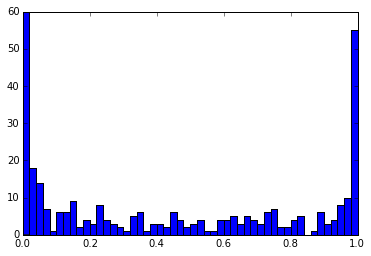

In [19]:
roi = nib.load(fname)
roi_arr = np.asarray(roi.get_data())
print(roi_arr.dtype)
roi_arr_not_nan = np.nan_to_num(roi_arr)
roi_arr_not_nan.sum()
#h = plt.hist(roi_arr.flatten())
h =plt.hist(roi_arr[roi_arr >0],bins=50)

In [20]:
DSIG = osp.join(DDIR, 'extracted_signals')

In [21]:
import utils.setup_filenames as suf
suf = reload(suf)
suf.rm_and_create(DSIG)

In [22]:
print(DSIG)
stat.S_IWGRP | stat.S_IWUSR | stat.S_IWOTH
stat.S_IWUSR
stat.S_IWGRP
print(stat.S_IWRITE, stat.S_IWUSR)
type(0o770)
%pwd

/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/extracted_signals
128 128


u'/home/jb/code/simpace/simpace'

## Step 3: load confounds 

In [23]:
print(DDIR)

/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc


(64, 64, 30) 20
int8
20


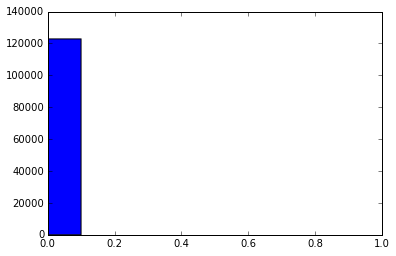

In [24]:

# extract csf time series
# dir temporary
DCSF = osp.join(DDIR, 'csf_mask')
csf_file = osp.join(DCSF, 'csf_map_final.nii.gz')
csf_img = nib.load(csf_file)
print(csf_img.shape, csf_img.get_data().sum())

print(csf_img.get_data().dtype)
h = plt.hist(csf_img.get_data().flatten())
print((csf_img.get_data().astype('bool') > 0.5).sum())


(196,)
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/csf_mask


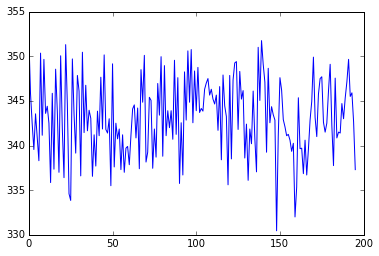

In [25]:
csf_sig, csf_iss, csf_inf = ucr.extract_signals(DCSF, 'csf_map_final.nii.gz', run0_4d)
plt.plot(csf_sig['csf_map_final.nii'])
print(csf_sig['csf_map_final.nii'].shape)
print(DCSF)

In [26]:
# load mvt parameters
DREALIGN = osp.join(DDIR, 'realign')
mvtfile = osp.join(DREALIGN,'rp_asub01_sess01_run01-0006.txt')
print(mvtfile)
run_len = 196

/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/realign/rp_asub01_sess01_run01-0006.txt


In [27]:
pat = 'rp_asub??_' + '*-0*.txt'
mvfile = gb.glob(osp.join(DREALIGN,pat))

In [28]:
mvtfile

'/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/realign/rp_asub01_sess01_run01-0006.txt'

In [29]:
mvt0, _ = ucr.extract_mvt(mvtfile, 0, run_len)
print(mvt0.shape)

(196, 6)


## Step 4: filter

In [30]:
osp.dirname(osp.dirname(DDIR))

'/home/jb/data/simpace/data/rename_files/sub01'

In [31]:
DDIR

'/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc'

In [32]:
dsess = osp.dirname(DDIR) # session directory is one up

In [33]:
import json
from pprint import pprint
fname = gb.glob(osp.join(dsess,"su*params"))
print(osp.join(dsess,"su*params"))
print(fname)
assert osp.isfile(fname[0])

/home/jb/data/simpace/data/rename_files/sub01/sess01/su*params
['/home/jb/data/simpace/data/rename_files/sub01/sess01/sub01_sess01_params']


In [34]:
with open(fname[0]) as param:
    data = json.load(param)

In [35]:
import utils._utils as ucr
ucr = reload(ucr)

In [36]:
nt = 196
dt = 2.
frametimes = np.linspace(0, (nt-1)*dt, nt)
bf_h = ucr._cosine_high_freq(10.05, frametimes)
bf_l = ucr._cosine_low_freq(128, frametimes)

bf = np.hstack((bf_l, bf_h))

True


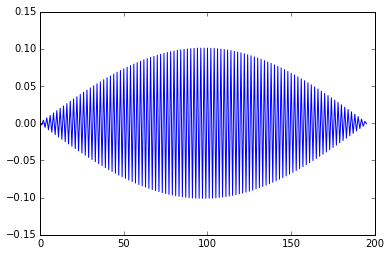

In [94]:
#_ = plt.imshow(bf, interpolation='nearest',aspect='auto')
print(np.any(bf.std(axis=0) < np.finfo(float).eps))
# bf.std(axis=0)
plt.plot(bf[:,-1])

array([[ 2.        ,  1.99992385],
       [ 2.        ,  1.99931465],
       [ 2.        ,  1.99809644],
       [ 2.        ,  1.9962696 ],
       [ 2.        ,  1.99383467]])

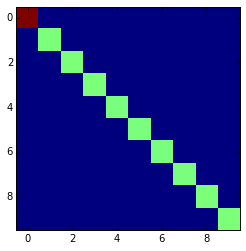

In [100]:
import scipy.fftpack as fft
bfsc = fft.dct(eye(180))
#plt.imshow(bfsc)
#plt.plot(bfsc[:,-1])
#plt.imshow(bf.T.dot(bf), interpolation='nearest')
plt.imshow(bfsc.T.dot(bfsc)[:10,:10], interpolation='nearest')
bfsc[:5,:2]

In [39]:
import utils._utils as ucr
ucr = reload(ucr)
import utils.setup_filenames as suf
suf = reload(suf)
from nilearn._utils import concat_niimgs

In [40]:
file_names = runs[0]
idx_run = 0
mask = mask_sess
TR = 2.0
VOLNB = 196

In [41]:
ddir = osp.dirname(osp.dirname(file_names[0])) # preproc dir
dsess = osp.dirname(ddir) # session directory is one up
droi = osp.join(ddir, 'registered_files')
dsig = osp.join(ddir, 'extracted_signals')
dreal = osp.join(ddir, 'realign')
# - parameter (condition name)
paramfile = gb.glob(osp.join(dsess,"sub??_sess??_params"))
paramfile = suf._check_glob_res(paramfile, ensure=1, files_only=True)
with open(paramfile) as fparam:
     param = json.load(fparam)
     mvt_cond = str(param['motion'][idx_run])
# - signal files
fn_sig = osp.join(dsig, 'signal_run{:02d}_'.format(idx_run) + mvt_cond)
fn_fsig = osp.join(dsig, 'filtered_signal_run{:02d}_'.format(idx_run)+mvt_cond)
# - csf file
dcsf = osp.join(ddir, 'csf_mask')
csf_filename =  'csf_map_final.nii.gz'
# - mvt file
# example : mvtfile = osp.join(dreal,'rp_asub01_sess01_run01-0006.txt')
mvtpat = 'rp_asub??_' + '*-0*.txt'
mvtfile = gb.glob(osp.join(dreal, mvtpat))
mvtfile = suf._check_glob_res(mvtfile, ensure=1, files_only=True)
# - atlas roi files
roi_prefix = 'rraal_*.nii'
                                                                                
#- other parameters:
low_freq = 0.01
high_freq = 0.15
dt = TR

mvtpat = ('rp_asub??_sess??_run{:02d}' + '*-00*.txt').format(idx_run+1)
mvtfile = gb.glob(osp.join(dreal, mvtpat))
mvtfile = suf._check_glob_res(mvtfile, ensure=1, files_only=True)
print("\n".join([dsess,ddir,paramfile,mvtfile]))

/home/jb/data/simpace/data/rename_files/sub01/sess01
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc
/home/jb/data/simpace/data/rename_files/sub01/sess01/sub01_sess01_params
/home/jb/data/simpace/data/rename_files/sub01/sess01/preproc/realign/rp_asub01_sess01_run01-0006.txt


In [42]:
run_4d = concat_niimgs(file_names, ensure_ndim=4)
signals, _issues, _info = ucr.extract_signals(droi, roi_prefix, run_4d, 
                                                    mask=mask, minvox=1)   
arr_sig, labels_sig = ucr._dict_signals_to_arr(signals)
print(arr_sig.shape)

(196, 102)


In [43]:
signals, _issues, _info = ucr.extract_signals(droi, roi_prefix, run_4d, 
                                                    mask=None, minvox=1)   

arr_sig, labels_sig = ucr._dict_signals_to_arr(signals)
print(arr_sig.shape)

for k in _info.keys()[:5]:
    print(k, _info[k])

(196, 105)
rraal_Vermis_4_5__________ 112
rraal_Thalamus_L__________ 193
rraal_Rolandic_Oper_L_____ 162
rraal_Frontal_Sup_Orb_R___ 164
rraal_Cerebelum_6_L_______ 201


In [44]:
suf.rm_and_create(dsig)
np.savez(fn_sig, arr_sig, labels_sig)

In [45]:
csf_arr, csf_labs = ucr.extract_roi_run(dcsf, csf_filename, run_4d, 
                    check_lengh=VOLNB, standardize=True)

(196, 1) 1.0 5.36685e-06


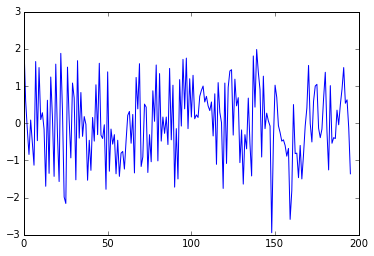

In [46]:
plt.plot(csf_arr)
print(csf_arr.shape, csf_arr.std(), csf_arr.mean())

In [47]:
bf_arr, bf_labs = ucr.extract_bf(low_freq, high_freq, VOLNB, dt, 
                                                            verbose=False)


In [48]:
mvt_arr, mvt_labs = ucr.extract_mvt(mvtfile, idx_run, VOLNB, verbose=1)

not to demean nb of col:  0
signals.mean()  1.03847391759e-17
(std < TINY).sum() =  0


In [49]:
counfounds = np.hstack((csf_arr, mvt_arr, bf_arr))
counfounds_labs = csf_labs + mvt_labs + bf_labs


In [50]:
counfounds.shape

(196, 93)

In [51]:
counfounds_labs[:10]

['csf', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz', 'lf000', 'lf001', 'lf002']

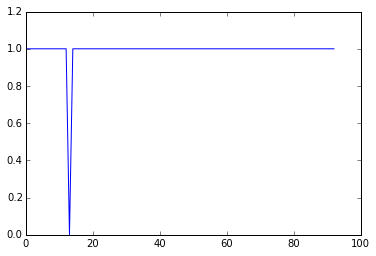

In [52]:
plt.plot(counfounds.std(axis=0))

In [53]:
arr_sig.shape

(196, 105)

In [54]:
f_arr_sig = ucr.R_proj(counfounds, arr_sig)

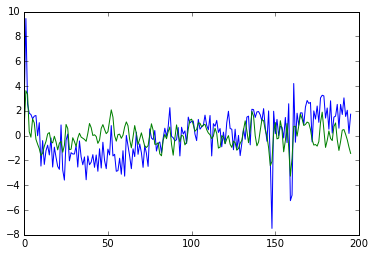

In [55]:
t = np.arange(arr_sig.shape[0])
idx = 0
plt.plot(t, arr_sig[:,idx]-arr_sig[:,idx].mean(), t, f_arr_sig[:,idx])
#plt.plot(t, arr_sig[:,44])

In [56]:
dsess = osp.dirname(ddir)
dbase = osp.dirname(osp.dirname(dsess))
layout = 'directory_layout.json'
dlo = osp.join(dbase, layout)
analy_param = 'analysis_parameters.json'
apr = osp.join(dbase, analy_param)
data_param = 'data_parameters.json'
dpr = osp.join(dbase, data_param)

In [57]:
import json


In [58]:
print(apr)
a = json.load(open(dlo))
b = json.load(open(apr))
c = json.load(open(dpr))

/home/jb/data/simpace/data/rename_files/analysis_parameters.json


In [59]:
print(a)
print(b)
print(c)

{u'pat': {u'sub+sess+': u'*sub{:02d}_sess{:02d}_', u'sub+sess+run+': u'*sub{:02d}_sess{:02d}_run{:02d}-', u'run+': u'*run{:02d}-', u'sess+': u'*sess{:02d}_', u'sub+': u'*sub{:02d}_', u'sess+run+': u'*sess{:02d}_run{:02d}-'}, u'wm': {u'@dir': u'@dir@runs@wm', u'roi_mask': u'wm_map_final.nii*', u'dir': u'wm_mask'}, u'csf': {u'@dir': u'@dir@runs@csf', u'roi_mask': u'csf_map_final.nii*', u'dir': u'csf_mask'}, u'atlas': {u'prepat': u'rraal_*.nii', u'dir': u'registered_files'}, u'spm_mvt': {u'mvtpost': u'00?.txt', u'mvtprm': u'rp_asub??_sess??_run*-00*.txt', u'mvtrun1+': u'rp_asub{:02d}_sess{:02d}_run01-0*.txt', u'mvtpref': u'rp_'}, u'dir': {u'runs': u'preproc', u'smooth': u'smooth', u'signals': u'extracted_signals', u'realign': u'realign', u'base': u'./', u'run+': u'run{:02d}', u'sess+': u'sess{:02d}', u'sub+': u'sub{:02d}'}, u'out': {u'signals': {u'signals+': u'signal_run{:02d}_', u'dir': u'extracted_signals', u'f_signals+': u'filtered_signal_run{:02d}_'}, u'sess_mask': {u'roi_mask': u'ses

In [60]:
a['atlas']['prepat']

u'rraal_*.nii'

In [61]:
b

{u'apply_csf': True,
 u'apply_filter': True,
 u'apply_mvt': True,
 u'apply_sess_mask': True,
 u'apply_wm': True,
 u'csf': {u'type': u'mean'},
 u'filter': {u'high_freq': 0.1, u'low_freq': 0.01},
 u'mvt': {u'type': u'6'},
 u'wm': {u'type': u'mean'},
 u'write_signals': True}

In [62]:
assert isinstance(b['apply_csf'],bool)
assert isinstance(b['filter'],dict)

In [63]:
print(dbase)
DIRLAYOUT = 'directory_layout.json'
DATAPARAM = 'data_parameters.json'
ANALPARAM = 'analysis_parameters.json'

/home/jb/data/simpace/data/rename_files


In [64]:
fn_layo = osp.join(dbase, DIRLAYOUT)
fn_data = osp.join(dbase, DATAPARAM)
fn_anal = osp.join(dbase, ANALPARAM)
                                     
with open(fn_layo) as flayo:
    dlayo = json.load(flayo)
with open(fn_data) as fdata:
    ddata = json.load(fdata)
with open(fn_anal) as fanal:
    danal = json.load(fanal)


In [65]:
params = {'layout': dlayo, 'data': ddata, 'analysis': danal}

In [66]:
params

{'analysis': {u'apply_csf': True,
  u'apply_filter': True,
  u'apply_mvt': True,
  u'apply_sess_mask': True,
  u'apply_wm': True,
  u'csf': {u'type': u'mean'},
  u'filter': {u'high_freq': 0.1, u'low_freq': 0.01},
  u'mvt': {u'type': u'6'},
  u'wm': {u'type': u'mean'},
  u'write_signals': True},
 'data': {u'TR': 2.0,
  u'nb_run': 4,
  u'nb_sess': 1,
  u'nb_sub': 1,
  u'nb_vol': 196},
 'layout': {u'atlas': {u'dir': u'registered_files', u'prepat': u'rraal_*.nii'},
  u'csf': {u'@dir': u'@dir@runs@csf',
   u'dir': u'csf_mask',
   u'roi_mask': u'csf_map_final.nii*'},
  u'dir': {u'base': u'./',
   u'realign': u'realign',
   u'run+': u'run{:02d}',
   u'runs': u'preproc',
   u'sess+': u'sess{:02d}',
   u'signals': u'extracted_signals',
   u'smooth': u'smooth',
   u'sub+': u'sub{:02d}'},
  u'out': {u'sess_mask': {u'dir': u'sess_mask', u'roi_mask': u'sess_mask.nii'},
   u'signals': {u'dir': u'extracted_signals',
    u'f_signals+': u'filtered_signal_run{:02d}_',
    u'signals+': u'signal_run{:02d}

In [67]:
DIRLAYOUT = 'directory_layout.json'
DATAPARAM = 'data_parameters.json'
ANALPARAM = 'analysis_parameters.json'

def get_params(dbase, verbose=False):
    """
    parameters:
    -----------
    dbase:  string
            base directory containing subjects directory
            and jason files
    """

    # Read json files at the base directory
    fn_layo = osp.join(dbase, DIRLAYOUT)
    fn_data = osp.join(dbase, DATAPARAM)
    fn_anal = osp.join(dbase, ANALPARAM)

    with open(fn_layo) as flayo:
        dlayo = json.load(flayo)
    with open(fn_data) as fdata:
        ddata = json.load(fdata)
    with open(fn_anal) as fanal:
        danal = json.load(fanal)

    params = {'layout': dlayo, 'data': ddata, 'analysis': danal}
    return params

def process_all(dbase, params=None, verbose=False):
    """
    parameters:
    -----------
    dbase:  string
            base directory containing subjects directory
            and jason files
    """
    if not params:
        params = get_params(dbase, verbose=verbose)
    
    dlayo = params['layout']
    ddata = params['data']

    # loop over subjects
    subj_idx = range(1,ddata['nb_sub']+1) # starts at 1, hence + 1
    subj_dirs = [osp.join(dbase, (dlayo['dir']['sub+']).format(idx)) for idx in subj_idx]
    # check all subj_dirs exists
    for sub_dir in subj_dirs:
        assert osp.isdir(sub_dir), "sub_dir"

    subjs_info = {}
    sub_curr = {}
    for sub_idx, sub_dir in enumerate(subj_dirs, 1): # start idx at 1
        sub_curr['sub_idx'] = sub_idx
        sub_curr['sub_dir'] = sub_dir
        sub_str = (dlayo['dir']['sub+']).format(sub_idx)
        subjs_info[sub_str] =  do_one_subject(sub_curr, params, verbose=verbose) 

    return subjs_info

def do_one_subject(sub_curr, params, verbose=False):
    """
    launch sessions processing for sub_curr 

    parameters:
    -----------
    sub_curr: dict 
            contains subject base directory
            contains subject index 
    params: dict
            parameters for layout, data and analysis
            
    """
    sub_idx, sub_dir = sub_curr['sub_idx'], sub_curr['sub_dir']
    nb_sess = params['data']['nb_sess']
    dlayo = params['layout']
    sess_idx = range(1, nb_sess+1)
    sess_dirs = [osp.join(sub_dir, (dlayo['dir']['sess+']).format(idx)) for idx in sess_idx]

    sesss_info = {} 
    sess_curr = {}
    for sess_idx, sess_dir in enumerate(sess_dirs, 1): # start idx at 1
        sess_curr['sess_idx'] = sess_idx
        sess_curr['sess_dir'] = sess_dir
        sess_str = (dlayo['dir']['sess+']).format(sub_idx)
        sesss_info[sess_str] = do_one_sess(sess_curr, sub_curr, params, verbose=verbose) 

    return sesss_info
    
def do_one_sess(sess_curr, sub_curr, params, verbose=False):
    """
    launch runs processing for sess_curr 

    parameters:
    -----------
    sess_curr: dict 
            contains sess base directory
            contains sess index 
    params: dict
            parameters for layout, data and analysis
    """            

    sess_idx = sess_curr['sess_idx']
    sess_dir = sess_curr['sess_dir']
    sub_idx = sub_curr['sub_idx']
    nb_runs = params['data']['nb_run'] 
    assert nb_runs == 4 # 4debug

    dlayo = params['layout']

    runs_dir = osp.join(sess_dir, dlayo['dir']['runs']) # should be preproc
    sess_curr['dir_runs'] = runs_dir

    dir_smooth_imgs = osp.join(runs_dir, dlayo['dir']['smooth'])
    sess_curr['dir_smooth_imgs'] = dir_smooth_imgs

    sess_curr['droi'] = osp.join(runs_dir, dlayo['atlas']['dir']) # 'registered_files'
    sess_curr['roi_prefix'] = dlayo['atlas']['prepat']            # 'rraal_*.nii'     
    sess_curr['dsig'] = osp.join(runs_dir, dlayo['out']['signals']['dir']) 

    save_is_true = params['analysis']['write_signals']
    if save_is_true: 
        # rm existing and recreate signal directory
        suf.rm_and_create(sess_curr['dsig'])

    sess_curr['dreal'] = osp.join(runs_dir, dlayo['dir']['realign'])

    #- csf dir and file
    sess_curr['csf_dir'] = osp.join(runs_dir, dlayo['csf']['dir'])
    csf_file = gb.glob(osp.join(sess_curr['csf_dir'], dlayo['csf']['roi_mask']))
    csf_file = suf._check_glob_res(csf_file, ensure=1, files_only=True)
    sess_curr['csf_filename'] =  csf_file

    #- csf dir and file
    sess_curr['wm_dir'] = osp.join(runs_dir, dlayo['wm']['dir'])
    wm_file = gb.glob(osp.join(sess_curr['wm_dir'], dlayo['wm']['roi_mask']))
    wm_file = suf._check_glob_res(wm_file, ensure=1, files_only=True)
    sess_curr['wm_filename'] =  wm_file

    #- Get runs' filenames
    #------------------------
    pat_imgs_files = dlayo['pat']['sub+sess+run+']+"*.nii*"
                                # requires idx for sub, sess and run
    runs_pat = [pat_imgs_files.format(sub_idx, sess_idx, run_idx) \
                                        for run_idx in range(1, nb_runs+1)]
                                # /!\  start idx at 1 requires nb_runs+1  /!\
    runs = [gb.glob(osp.join(dir_smooth_imgs, pat)) for pat in runs_pat]
    # /!\ATTENTION:/!\ must sort the files with filename, should sort in time
    for run in runs: run.sort()
    sess_curr['runs'] = runs
    
    # compute session wide mask
    #-----------------------------------------------------
    # compute_epi_mask(runs[0], opening=1, connected=True)
    if params['analysis']['apply_sess_mask']:
        sess_mask = msk.compute_multi_epi_mask(runs, lower_cutoff=0.2, 
                    upper_cutoff=0.85, connected=True, opening=2, threshold=0.5)
        # store sess mask
        dir_mask = osp.join(runs_dir, dlayo['out']['sess_mask']['dir'])
        suf.rm_and_create(dir_mask)
        sess_mask.to_filename(osp.join(dir_mask, dlayo['out']['sess_mask']['roi_mask']))
    else:
        sess_mask = None
    sess_curr['mask'] = sess_mask

    # TODO
    # check mask is reasonable - how ???

    # - mvt file
    # example : mvtfile = osp.join(dreal,'rp_asub01_sess01_run01-0006.txt')
    # /!\ will always be run01 for spm /!\
    mvtpat = dlayo['spm_mvt']['mvtrun1+'].format(sub_idx, sess_idx) 
    mvtfile = gb.glob(osp.join(sess_curr['dreal'], mvtpat))
    mvtfile = suf._check_glob_res(mvtfile, ensure=1, files_only=True)
    sess_curr['mvtfile'] = mvtfile

    # - parameter file for condition names
    param_pattern = (dlayo['pat']['sub+sess+']).format(sub_idx, sess_idx)
    paramfile = gb.glob(osp.join(sess_dir, param_pattern + "params"))
    paramfile = suf._check_glob_res(paramfile, ensure=1, files_only=True)
    with open(paramfile) as fparam:
         sess_param = json.load(fparam)

    runs_info = {}
    run_curr = {}
    for idx_run, run in enumerate(runs, 1): # /!\ starts at 1 /!\
        run_curr['run_idx'] = idx_run
        run_curr['file_names'] = run
        # TODO : fix this to have sess_param return motion['run1']='HIGH' etc
        run_curr['motion'] = sess_param['motion'][idx_run-1] # sess_param['motion'] is 0 based

        runs_info["run{:02d}".format(idx_run)] = \
                    do_one_run(run_curr, sess_curr, sub_curr, params, verbose=verbose)

    return runs_info

def do_one_run(run_curr, sess_curr, sub_curr, params, verbose=False):
    """
    """
    run_info = {}
    nvol = params['data']['nb_vol']
    dt = params['data']['TR']
    nb_run = params['data']['nb_run']

    file_names = run_curr['file_names']
    run_idx = run_curr['run_idx']
    run_idx0 = run_idx - 1
    assert run_idx0 >= 0
    assert run_idx0 < nb_run

    #sub_idx = sub_curr['sub_idx']
    #sess_idx = sess_curr['sess_idx']
    mvt_cond = run_curr['motion']
    dsig = sess_curr['dsig']
    mask = sess_curr['mask']

    low_freq = params['analysis']['filter']['low_freq']
    high_freq = params['analysis']['filter']['high_freq']
    
    # signal file names
    #-------------------
    _fn_sig = params['layout']['out']['signals']['signals+'] 
    _fn_fsig = params['layout']['out']['signals']['f_signals+'] 
    fn_sig = osp.join(dsig, _fn_sig.format(run_idx) + mvt_cond)
    fn_fsig = osp.join(dsig, _fn_fsig.format(run_idx)+mvt_cond)

    # extract signals and save them in preproc/roi_signals
    #-----------------------------------------------------
    run_4d = concat_niimgs(file_names, ensure_ndim=4)
    signals, _issues, _info = ucr.extract_signals(sess_curr['droi'], 
                                                  sess_curr['roi_prefix'], run_4d, 
                                                  mask=mask, minvox=1)   
    # construct matrix of counfounds
    #-----------------------------------------------------
    #--- get WM 

    #--- get CSF
    csf_arr, csf_labs = ucr.extract_roi_run(
                            sess_curr['csf_dir'], sess_curr['csf_filename'], 
                            run_4d, check_lengh=nvol, verbose=verbose)
    #--- get MVT
    mvt_arr, mvt_labs = ucr.extract_mvt(sess_curr['mvtfile'], run_idx0, nvol, 
                                                                verbose=verbose)
    #--- get cosine functions;
    bf_arr, bf_labs = ucr.extract_bf(low_freq, high_freq, nvol, dt, 
                                                                verbose=verbose)
    #--- put it together  
    arr_counf = np.hstack((csf_arr, mvt_arr, bf_arr))
    labs_counf = csf_labs + mvt_labs + bf_labs
    if verbose:
       print("csf.shape {}, mvt.shape {}, bf.shape {}".format(
                     csf_arr.shape, mvt_arr.shape, bf_arr.shape))
    run_info['shapes'] = (csf_arr.shape, mvt_arr.shape, bf_arr.shape)
    run_info['mean_csf'] = csf_arr.mean(axis=0)
    run_info['mean_mvt'] = mvt_arr.mean(axis=0)

    # filter and compute correlation
    #-----------------------------------------------------
    arr_sig, labels_sig = ucr._dict_signals_to_arr(signals)
    arr_sig_f = ucr.R_proj(arr_counf, arr_sig)

    # save filtered signals 
    save_is_true = params['analysis']['write_signals']
    if save_is_true:
        np.savez(fn_sig, arr_sig=arr_sig, labels_sig=labels_sig) 
        np.savez(fn_fsig, arr_sig_f=arr_sig_f, labels_sig=labels_sig, 
                      arr_counf=arr_counf, labs_counf=labs_counf)
    else:
        run_info['signals'] = dict(arr_sig=arr_sig, labels_sig=labels_sig, 
                                    issues=_issues, info=_info)
        run_info['f_signals'] = dict(arr_sig_f=arr_sig_f, labels_sig=labels_sig,
                                     arr_counf=arr_counf, labs_counf=labs_counf)

    return run_info


In [68]:
dbase = '/home/jb/data/simpace/data/rename_files'
get_params(dbase, verbose=False)
params['analysis']['write_signals'] = False
params['analysis']['apply_sess_mask'] = False


In [69]:
print(params.keys())
print(params['layout'])
print(params['analysis'])

['data', 'layout', 'analysis']
{u'pat': {u'sub+sess+': u'*sub{:02d}_sess{:02d}_', u'sub+sess+run+': u'*sub{:02d}_sess{:02d}_run{:02d}-', u'run+': u'*run{:02d}-', u'sess+': u'*sess{:02d}_', u'sub+': u'*sub{:02d}_', u'sess+run+': u'*sess{:02d}_run{:02d}-'}, u'wm': {u'@dir': u'@dir@runs@wm', u'roi_mask': u'wm_map_final.nii*', u'dir': u'wm_mask'}, u'csf': {u'@dir': u'@dir@runs@csf', u'roi_mask': u'csf_map_final.nii*', u'dir': u'csf_mask'}, u'atlas': {u'prepat': u'rraal_*.nii', u'dir': u'registered_files'}, u'spm_mvt': {u'mvtpost': u'00?.txt', u'mvtprm': u'rp_asub??_sess??_run*-00*.txt', u'mvtrun1+': u'rp_asub{:02d}_sess{:02d}_run01-0*.txt', u'mvtpref': u'rp_'}, u'dir': {u'runs': u'preproc', u'smooth': u'smooth', u'signals': u'extracted_signals', u'realign': u'realign', u'base': u'./', u'run+': u'run{:02d}', u'sess+': u'sess{:02d}', u'sub+': u'sub{:02d}'}, u'out': {u'signals': {u'signals+': u'signal_run{:02d}_', u'dir': u'extracted_signals', u'f_signals+': u'filtered_signal_run{:02d}_'}, u'

In [70]:
params['analysis']['write_signals'] = False
subjs_info = process_all(dbase, params=params, verbose=False)

In [71]:
print(subjs_info['sub01']['sess01']['run01']['signals'].keys())
signals_dict = subjs_info['sub01']['sess01']['run01']['signals']
print(type(signals_dict['labels_sig']))
print(type(signals_dict['arr_sig']))

['info', 'arr_sig', 'labels_sig', 'issues']
<type 'list'>
<type 'numpy.ndarray'>


In [72]:
labs_sig = subjs_info['sub01']['sess01']['run01']['f_signals']['labels_sig']
info_sig = subjs_info['sub01']['sess01']['run01']['signals']['info']
arr_sig = subjs_info['sub01']['sess01']['run01']['signals']['arr_sig']

In [73]:
dtest = '/home/jb/code/simpace/simpace/tests'
mat_file = osp.join(dtest, "sub01_session_1_raw_ROI_timeseries.mat")

In [74]:
import scipy.io as sio
from numpy.testing import assert_allclose, assert_array_equal

to_check = sio.loadmat(mat_file)

In [75]:
to_check.keys()

['all_rois', 'time_series', '__globals__', 'Nvox', '__header__', '__version__']

In [76]:
to_check['all_rois'][1][0][0]
to_check['time_series'][0][0]


array([ 335.36842105,  352.89473684,  359.47368421,  356.44736842])

In [77]:
to_check['Nvox'][0]

array([ 38,  38, 192, 287, 361, 304, 161, 163,   0,   0,  22,  31, 155,
       107, 201, 229,   0,   0,   0,   0,   0,   0, 122, 176,  16,   7,
       234, 208, 315, 388,  75,  49, 238, 260, 181, 220, 270, 285, 416,
       365,  99, 124, 818, 157, 169, 845, 593, 499, 377, 150, 164, 674,
       285, 329,  35,  43, 148, 153, 317, 298, 368, 366, 149, 170, 543,
       339, 223, 235,  34,  50,  50,  49,  99, 136, 222, 133, 391, 235,
       338, 365, 636, 633, 590, 558, 584, 552, 165, 176, 147, 126, 162,
       217, 373, 379, 224, 313, 272, 433, 794, 737,   0,  43, 128, 186,
       379, 503, 193, 193,   2,   7,  37, 112,  66,  24,   0,   0, 202,  20], dtype=uint16)

In [78]:
nvox = to_check['Nvox'][0]
for idx, roi in enumerate(to_check['all_rois'][:10]):
    k, _ = osp.splitext(osp.basename(roi[0][0]))
    in_sig = k in labs_sig
    print(k, in_sig)
    if in_sig: print(nvox[idx], info_sig[k])

rraal_Amygdala_L__________ True
38 38
rraal_Amygdala_R__________ True
38 38
rraal_Angular_L___________ True
192 192
rraal_Angular_R___________ True
287 287
rraal_Calcarine_L_________ True
361 361
rraal_Calcarine_R_________ True
304 304
rraal_Caudate_L___________ True
161 161
rraal_Caudate_R___________ True
163 163
rraal_Cerebelum_10_L______ False
rraal_Cerebelum_10_R______ False


In [79]:
[(k,info_sig[k]) for k in sorted(info_sig.keys())][-5:]

[(u'rraal_Vermis_1_2__________', 7),
 (u'rraal_Vermis_3____________', 37),
 (u'rraal_Vermis_4_5__________', 112),
 (u'rraal_Vermis_6____________', 66),
 (u'rraal_Vermis_7____________', 24)]

In [80]:
arielle_roi = []
[osp.splitext(osp.basename(roi[0][0]))[0] for roi in to_check['all_rois']][-8:]

[u'rraal_Vermis_3____________',
 u'rraal_Vermis_4_5__________',
 u'rraal_Vermis_6____________',
 u'rraal_Vermis_7____________',
 u'rraal_Vermis_8____________',
 u'rraal_Vermis_9____________',
 u'wm_map_0.99_erode',
 u'csf_map_0.93_erode']

In [81]:
nvox = to_check['Nvox'][0]
arrielle_nvox = [nvox[idx] for idx in range(len(nvox)) if nvox[idx] != 0]
jb_nvox = np.asarray([info_sig[k] for k in sorted(info_sig.keys())])
assert_array_equal(np.asarray(arrielle_nvox)[:-2], np.asarray(jb_nvox))
